# Composition of signatures within TTWA boundaries

In [1]:
import geopandas
import pandas
import tobler

tobler.__version__

'0.9.0'

https://services1.arcgis.com/ESMARspQHYMw9BZ9/ArcGIS/rest/services/TTWA_2011_UK/FeatureServer

In [2]:
url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/TTWA_2011_UK/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryPolygon&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token="

In [3]:
ttwa = geopandas.read_file(url)

In [4]:
ttwa

,TTWA11CD,geometry
0,E30000004,"POLYGON ((-1.34865 53.58333, -1.32673 53.55813..."
1,E30000018,"POLYGON ((-1.93086 53.95027, -1.89833 53.92398..."
2,E30000029,"POLYGON ((-1.73679 53.70811, -1.73128 53.68037..."
3,E30000039,"POLYGON ((-2.00451 54.17288, -1.99254 54.15528..."
4,E30000046,"POLYGON ((-2.26489 50.75912, -2.24239 50.75563..."
...,...,...
223,W22000030,"MULTIPOLYGON (((-4.77992 52.76561, -4.80242 52..."
224,W22000031,"POLYGON ((-3.14509 53.26082, -3.17735 53.24382..."
225,W22000032,"POLYGON ((-3.47007 51.82850, -3.47633 51.80947..."
226,W22000033,"POLYGON ((-3.48307 52.86552, -3.50541 52.84191..."


In [5]:
# drop NI
ttwa = ttwa[~ttwa.TTWA11CD.str.startswith("N")]

<AxesSubplot:>

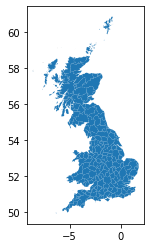

In [6]:
ttwa.plot()

In [30]:
ttwa.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa.pq")

<ipython-input-30-01f59cdfba9b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ttwa.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa.pq")


In [2]:
ttwa = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa.pq")

In [3]:
signatures = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_simplified.pq")

In [4]:
# drop an outlier island
signatures = signatures.drop(96691)

In [5]:
types = {
    "0_0": "Countryside agriculture",
    "1_0": "Accessible suburbia",
    "3_0": "Open sprawl",
    "4_0": "Wild countryside",
    "5_0": "Warehouse/Park land",
    "6_0": "Gridded residential quarters",
    "7_0": "Urban buffer",
    "8_0": "Disconnected suburbia",
    "2_0": "Dense residential neighbourhoods",
    "2_1": "Connected residential neighbourhoods",
    "2_2": "Dense urban neighbourhoods",
    "9_0": "Local urbanity",
    "9_1": "Concentrated urbanity",
    "9_2": "Regional urbanity",
    "9_4": "Metropolitan urbanity",
    "9_5": "Hyper concentrated urbanity",
}

signatures["signature_type"] = signatures["signature_type"].map(types)

In [6]:
signatures = signatures[["signature_type", "geometry"]].dropna()

In [7]:
signatures

,signature_type,geometry
0,Countryside agriculture,"POLYGON ((62219.999 798499.999, 62109.999 7985..."
1,Countryside agriculture,"POLYGON ((63507.682 796515.168, 63471.096 7965..."
2,Countryside agriculture,"POLYGON ((65953.174 802246.171, 65523.864 8023..."
3,Countryside agriculture,"POLYGON ((67297.740 803435.799, 67220.290 8034..."
4,Countryside agriculture,"POLYGON ((75760.000 852669.999, 75699.999 8527..."
...,...,...
96686,Hyper concentrated urbanity,"POLYGON ((528530.169 181095.720, 528544.721 18..."
96687,Hyper concentrated urbanity,"POLYGON ((528602.733 181135.451, 528572.629 18..."
96688,Hyper concentrated urbanity,"POLYGON ((528643.907 181217.443, 528632.000 18..."
96689,Hyper concentrated urbanity,"POLYGON ((528734.583 181316.821, 528722.252 18..."


In [8]:
%%time
interpolated = tobler.area_weighted.area_interpolate(signatures, ttwa.to_crs(signatures.crs), categorical_variables=["signature_type"], n_jobs=-1)

CPU times: user 5.63 s, sys: 304 ms, total: 5.93 s
Wall time: 56.2 s


In [10]:
interpolated.columns = [c[15:] if c != "geometry" else c for c  in interpolated.columns]

In [11]:
interpolated = interpolated[~interpolated.geometry.isna()]

In [12]:
interpolated["TTWA11CD"] = ttwa.TTWA11CD.values

In [27]:
import pandas

names = pandas.read_csv("https://opendata.arcgis.com/api/v3/datasets/9ac894d3086641bebcbfa9960895db39_0/downloads/data?format=csv&spatialRefId=4326")

HTTPError: HTTP Error 500: Internal Server Error

In [31]:
names.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_names.pq")

In [14]:
names = pandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_names.pq")

In [15]:
interpolated = interpolated.merge(names[["TTWA11CD", "TTWA11NM"]], on="TTWA11CD", how="left")

In [16]:
interpolated

,Countryside agriculture,Accessible suburbia,Open sprawl,Wild countryside,Warehouse/Park land,Gridded residential quarters,Urban buffer,Disconnected suburbia,Dense residential neighbourhoods,Connected residential neighbourhoods,Dense urban neighbourhoods,Local urbanity,Concentrated urbanity,Regional urbanity,Metropolitan urbanity,Hyper concentrated urbanity,geometry,TTWA11CD,TTWA11NM
0,0.223470,0.043759,0.176207,0.078137,1.209109e-03,0.000215,0.464410,0.003625,0.006018,7.622296e-04,0.002179,0.000008,0.0,0.000000,0.000000,0.0,"POLYGON ((443116.607 409861.824, 444593.769 40...",E30000004,Barnsley
1,0.167767,0.044535,0.228543,0.031195,8.260556e-03,0.002243,0.431150,0.008945,0.032706,1.263258e-02,0.023457,0.008332,0.0,0.000230,0.000000,0.0,"POLYGON ((404536.924 450487.224, 406675.831 44...",E30000018,Bradford
2,0.506016,0.008178,0.078606,0.116988,7.743638e-03,0.000413,0.252566,0.004335,0.018123,1.105669e-03,0.005320,0.000605,0.0,0.000000,0.000000,0.0,"POLYGON ((417371.807 423577.976, 417747.206 42...",E30000029,Halifax
3,0.333247,0.000010,0.002516,0.626520,6.712196e-04,0.000000,0.036192,0.000069,0.000568,4.415132e-07,0.000182,0.000000,0.0,0.000000,0.000000,0.0,"POLYGON ((399705.754 475251.492, 400486.847 47...",E30000039,Skipton
4,0.803093,0.003389,0.021314,0.029620,4.454053e-03,0.000505,0.121557,0.000286,0.004360,4.049208e-04,0.000706,0.000240,0.0,0.000074,0.000021,0.0,"POLYGON ((381318.618 95599.564, 382904.110 952...",E30000046,Dorchester and Weymouth
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.294169,0.000185,0.000677,0.637449,1.737449e-05,0.000003,0.031029,0.000000,0.000199,1.370748e-05,0.000000,0.000000,0.0,0.000000,0.000000,0.0,"MULTIPOLYGON (((212467.543 322328.962, 210862....",W22000030,Pwllheli and Porthmadog
214,0.335685,0.009770,0.006090,0.555019,3.346282e-04,0.001034,0.089543,0.000154,0.000000,2.896387e-04,0.000000,0.000000,0.0,0.000000,0.000000,0.0,"POLYGON ((323624.950 374399.714, 321442.625 37...",W22000031,Rhyl
215,0.285298,0.017182,0.035248,0.108456,1.686457e-02,0.007052,0.510910,0.001141,0.002975,1.466345e-03,0.001266,0.000990,0.0,0.000086,0.000000,0.0,"POLYGON ((298705.805 215503.170, 298231.853 21...",W22000032,Swansea
216,0.226700,0.000080,0.000736,0.749014,8.903418e-07,0.000000,0.016699,0.000098,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,"POLYGON ((300174.007 330847.935, 298615.652 32...",W22000033,Tywyn and Dolgellau


In [17]:
interpolated.columns = ['Countryside agriculture', 'Accessible suburbia', 'Open sprawl',
       'Wild countryside', 'Warehouse/Park land', 'Gridded residential quarters',
       'Urban buffer', 'Disconnected suburbia',
       'Dense residential neighbourhoods',
       'Connected residential neighbourhoods', 'Dense urban neighbourhoods',
       'Local urbanity', 'Concentrated urbanity', 'Regional urbanity',
       'Metropolitan urbanity', 'Hyper concentrated urbanity', 'geometry', 'TTWA11CD',
       'TTWA11NM']

In [18]:
interpolated = geopandas.GeoDataFrame(interpolated, crs=27700)

In [19]:
interpolated.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

/tmp/ipykernel_420582/3951706392.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  interpolated.to_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")


<AxesSubplot:>

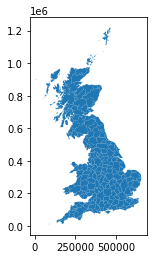

In [20]:
interpolated.plot()

In [5]:
interpolated = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

In [21]:
import matplotlib.pyplot as plt
import urbangrammar_graphics as ugg

In [22]:
plot_data = interpolated.set_index("TTWA11NM").T.drop(["geometry", "TTWA11CD"])
plot_data

TTWA11NM,Barnsley,Bradford,Halifax,Skipton,Dorchester and Weymouth,Falmouth,Grantham,Hastings,Hexham,Isle of Wight,...,Cardiff,Cardigan,Colwyn Bay,Llanelli,Merthyr Tydfil,Pwllheli and Porthmadog,Rhyl,Swansea,Tywyn and Dolgellau,Wrexham
Countryside agriculture,0.22347,0.167767,0.506016,0.333247,0.803093,0.818335,0.895052,0.767591,0.094503,0.599603,...,0.195818,0.523145,0.248822,0.314656,0.355109,0.294169,0.335685,0.285298,0.2267,0.677904
Accessible suburbia,0.043759,0.044535,0.008178,0.00001,0.003389,0.001462,0.003266,0.029322,0.0,0.025276,...,0.026761,0.0,0.008323,0.000882,0.001534,0.000185,0.00977,0.017182,0.00008,0.008354
Open sprawl,0.176207,0.228543,0.078606,0.002516,0.021314,0.014444,0.008395,0.015181,0.000812,0.019297,...,0.104238,0.000554,0.006357,0.004573,0.04385,0.000677,0.00609,0.035248,0.000736,0.019103
Wild countryside,0.078137,0.031195,0.116988,0.62652,0.02962,0.025869,0.00005,0.000017,0.897572,0.000087,...,0.0,0.457116,0.666861,0.614383,0.203098,0.637449,0.555019,0.108456,0.749014,0.068111
Warehouse/Park land,0.001209,0.008261,0.007744,0.000671,0.004454,0.000537,0.000426,0.000163,0.000008,0.000908,...,0.033123,0.000037,0.002164,0.000003,0.009065,0.000017,0.000335,0.016865,0.000001,0.003938
Gridded residential quarters,0.000215,0.002243,0.000413,0.0,0.000505,0.003124,0.000075,0.0,0.0,0.006657,...,0.018411,0.0,0.0008,0.001571,0.002301,0.000003,0.001034,0.007052,0.0,0.000004
Urban buffer,0.46441,0.43115,0.252566,0.036192,0.121557,0.094407,0.09079,0.165562,0.007011,0.32411,...,0.579492,0.007042,0.059214,0.059388,0.382751,0.031029,0.089543,0.51091,0.016699,0.216287
Disconnected suburbia,0.003625,0.008945,0.004335,0.000069,0.000286,0.002359,0.000676,0.003296,0.00001,0.000196,...,0.007812,0.000003,0.000006,0.000143,0.000539,0.0,0.000154,0.001141,0.000098,0.002296
Dense residential neighbourhoods,0.006018,0.032706,0.018123,0.000568,0.00436,0.000202,0.001139,0.004595,0.000085,0.003108,...,0.008038,0.0,0.000323,0.000008,0.000775,0.000199,0.0,0.002975,0.0,0.002831
Connected residential neighbourhoods,0.000762,0.012633,0.001106,0.0,0.000405,0.001662,0.000002,0.003681,0.0,0.000155,...,0.008753,0.0,0.002737,0.000003,0.000977,0.000014,0.00029,0.001466,0.0,0.000426


In [23]:
cmap = ugg.get_colormap(20, randomize=False)
cols = cmap.colors

symbology = {'0_0': cols[16],
             '1_0': cols[15],
             '3_0': cols[9],
             '4_0': cols[12],
             '5_0': cols[21],
             '6_0': cols[8],
             '7_0': cols[4],
             '8_0': cols[18],
             '2_0': cols[6],
             '2_1': cols[23],
             '2_2': cols[19],
             '9_0': cols[7],
             '9_1': cols[3],
             '9_2': cols[22],
             '9_4': cols[11],
             '9_5': cols[14],
            }
symbology = {types[k]:v for k, v in symbology.items()}

<AxesSubplot:xlabel='TTWA11NM'>

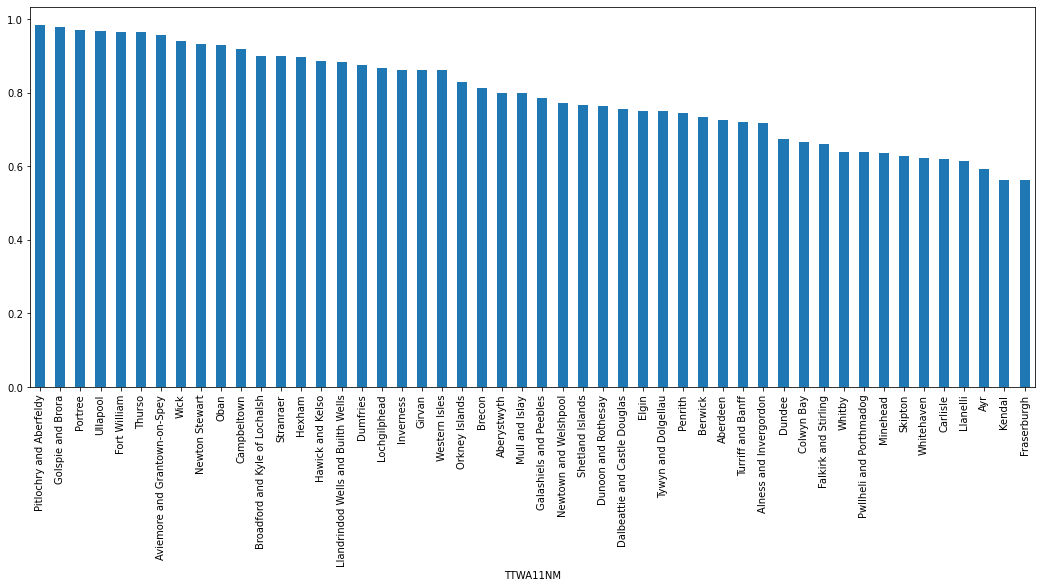

In [24]:
plot_data.T["Wild countryside"].sort_values(ascending=False).iloc[:50].plot.bar(figsize=(18, 7))

FileNotFoundError: [Errno 2] No such file or directory: '../../urbangrammar_samba/spatial_signatures/esda/ttwa_maps/Warehouse/Park land.png'

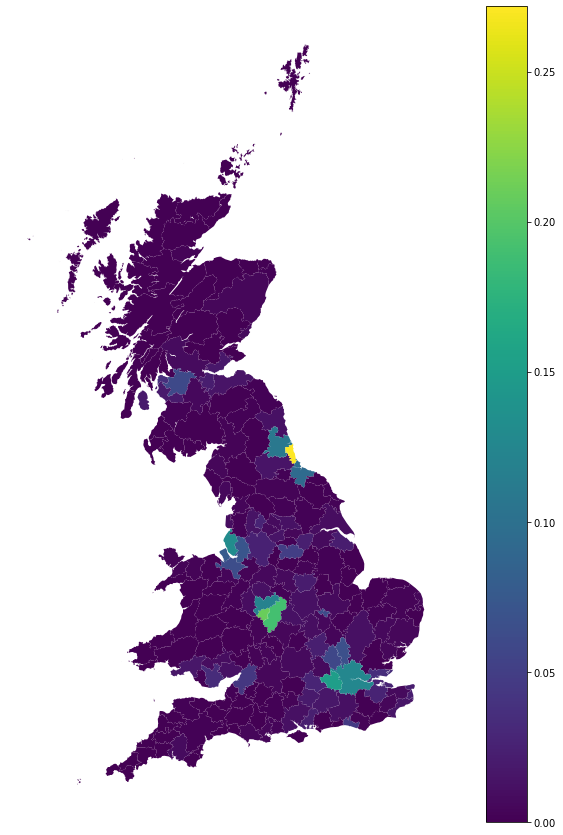

In [25]:
for sig in plot_data.index:
    
    ax = interpolated.plot(sig, figsize=(15, 15), legend=True)
    ax.axis('off')
    plt.savefig(f"../../urbangrammar_samba/spatial_signatures/esda/ttwa_maps/{sig}.png")
    plt.close()

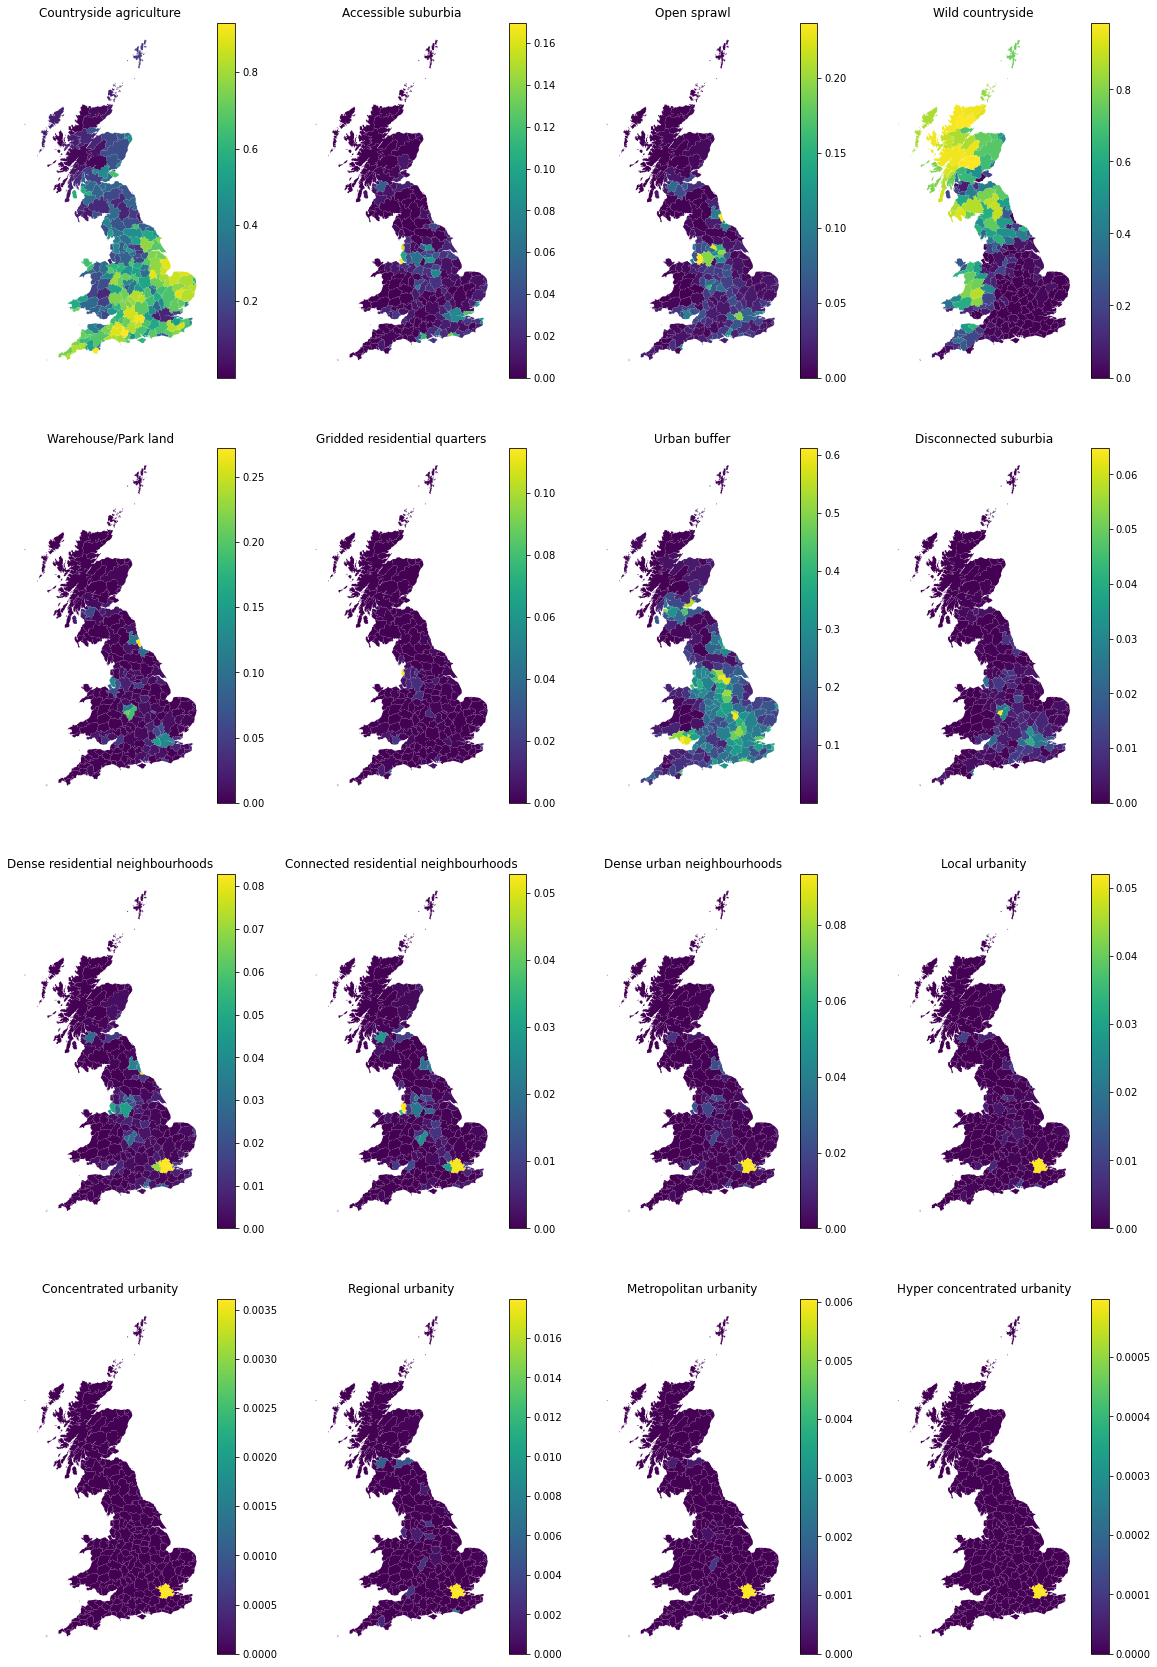

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(20, 30))
axs = axs.flatten()
for i, sig in enumerate(plot_data.index):
    interpolated.plot(sig, ax=axs[i], legend=True)
    axs[i].axis("off")
    axs[i].set_title(sig)

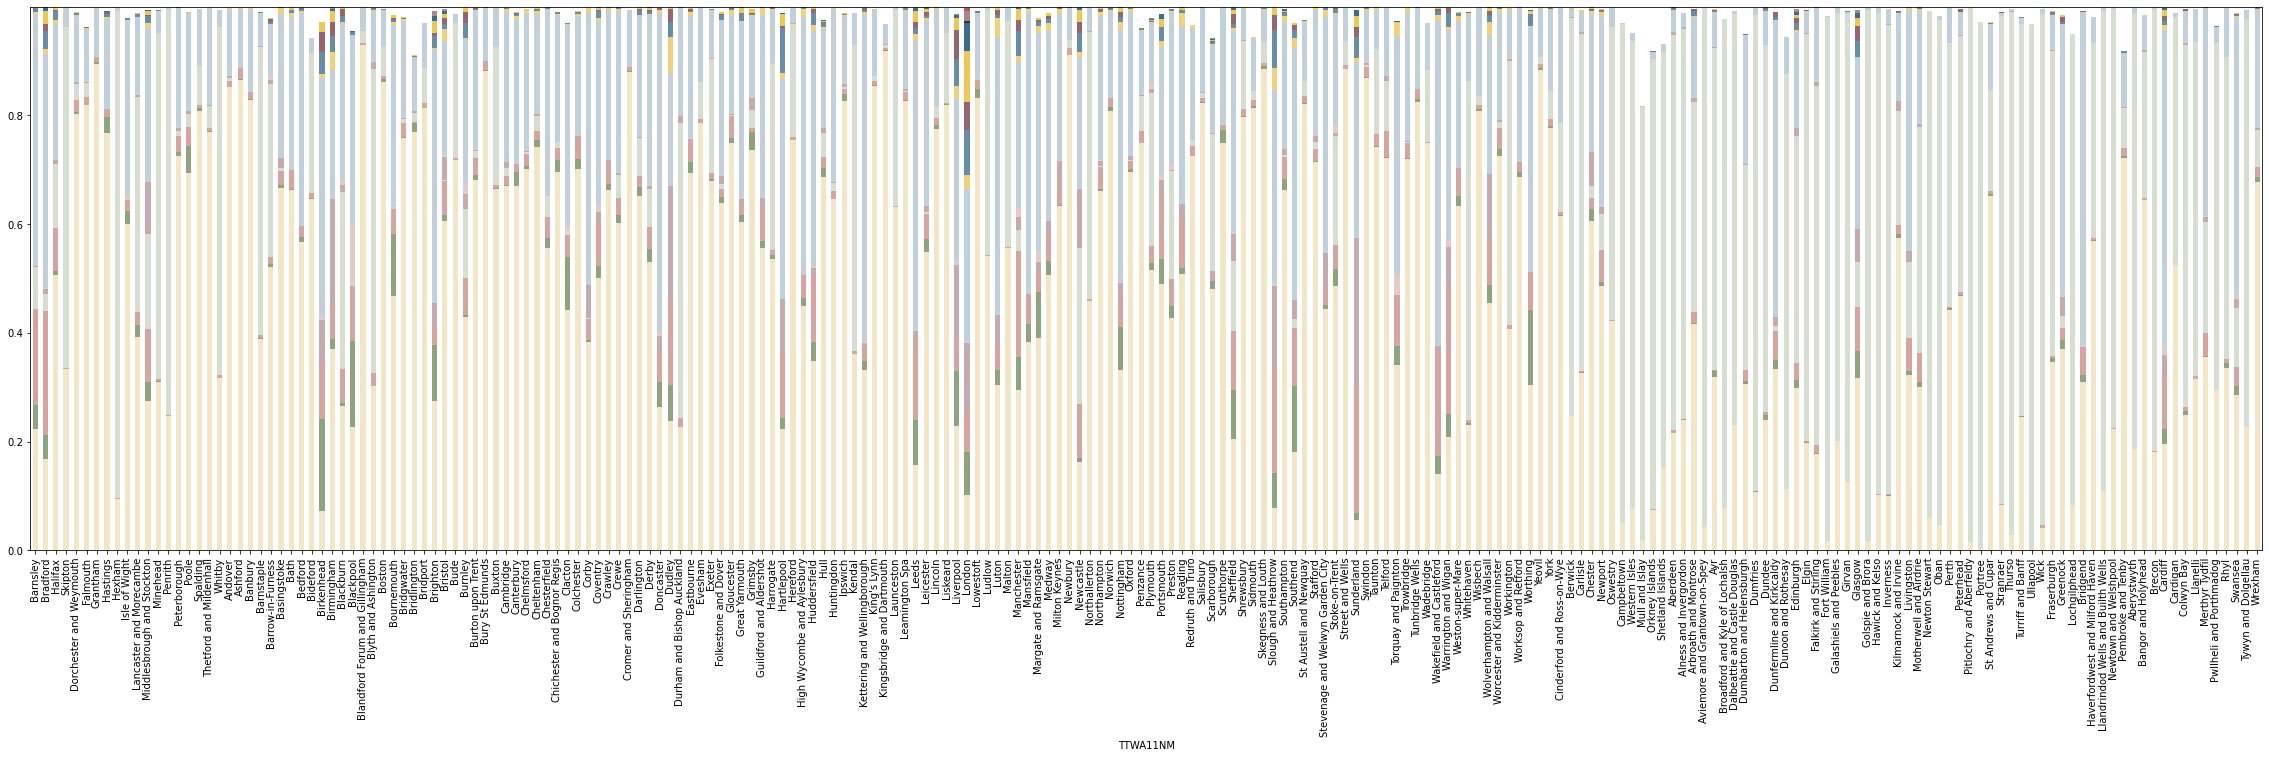

In [27]:
ax = plot_data.T.plot.bar(color=list(symbology.values()), stacked=True, figsize=(40, 10), legend=False)

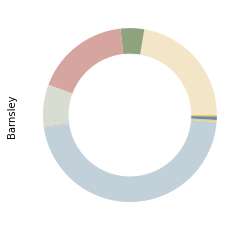

In [28]:
ax = plot_data["Barnsley"].plot.pie(colors=list(symbology.values()), labels=None, normalize=True)
ax.add_artist(plt.Circle((0,0), .7, color="w"))

In [29]:
plot_data

TTWA11NM,Barnsley,Bradford,Halifax,Skipton,Dorchester and Weymouth,Falmouth,Grantham,Hastings,Hexham,Isle of Wight,...,Cardiff,Cardigan,Colwyn Bay,Llanelli,Merthyr Tydfil,Pwllheli and Porthmadog,Rhyl,Swansea,Tywyn and Dolgellau,Wrexham
Countryside agriculture,0.22347,0.167767,0.506016,0.333247,0.803093,0.818335,0.895052,0.767591,0.094503,0.599603,...,0.195818,0.523145,0.248822,0.314656,0.355109,0.294169,0.335685,0.285298,0.2267,0.677904
Accessible suburbia,0.043759,0.044535,0.008178,0.00001,0.003389,0.001462,0.003266,0.029322,0.0,0.025276,...,0.026761,0.0,0.008323,0.000882,0.001534,0.000185,0.00977,0.017182,0.00008,0.008354
Open sprawl,0.176207,0.228543,0.078606,0.002516,0.021314,0.014444,0.008395,0.015181,0.000812,0.019297,...,0.104238,0.000554,0.006357,0.004573,0.04385,0.000677,0.00609,0.035248,0.000736,0.019103
Wild countryside,0.078137,0.031195,0.116988,0.62652,0.02962,0.025869,0.00005,0.000017,0.897572,0.000087,...,0.0,0.457116,0.666861,0.614383,0.203098,0.637449,0.555019,0.108456,0.749014,0.068111
Warehouse/Park land,0.001209,0.008261,0.007744,0.000671,0.004454,0.000537,0.000426,0.000163,0.000008,0.000908,...,0.033123,0.000037,0.002164,0.000003,0.009065,0.000017,0.000335,0.016865,0.000001,0.003938
Gridded residential quarters,0.000215,0.002243,0.000413,0.0,0.000505,0.003124,0.000075,0.0,0.0,0.006657,...,0.018411,0.0,0.0008,0.001571,0.002301,0.000003,0.001034,0.007052,0.0,0.000004
Urban buffer,0.46441,0.43115,0.252566,0.036192,0.121557,0.094407,0.09079,0.165562,0.007011,0.32411,...,0.579492,0.007042,0.059214,0.059388,0.382751,0.031029,0.089543,0.51091,0.016699,0.216287
Disconnected suburbia,0.003625,0.008945,0.004335,0.000069,0.000286,0.002359,0.000676,0.003296,0.00001,0.000196,...,0.007812,0.000003,0.000006,0.000143,0.000539,0.0,0.000154,0.001141,0.000098,0.002296
Dense residential neighbourhoods,0.006018,0.032706,0.018123,0.000568,0.00436,0.000202,0.001139,0.004595,0.000085,0.003108,...,0.008038,0.0,0.000323,0.000008,0.000775,0.000199,0.0,0.002975,0.0,0.002831
Connected residential neighbourhoods,0.000762,0.012633,0.001106,0.0,0.000405,0.001662,0.000002,0.003681,0.0,0.000155,...,0.008753,0.0,0.002737,0.000003,0.000977,0.000014,0.00029,0.001466,0.0,0.000426


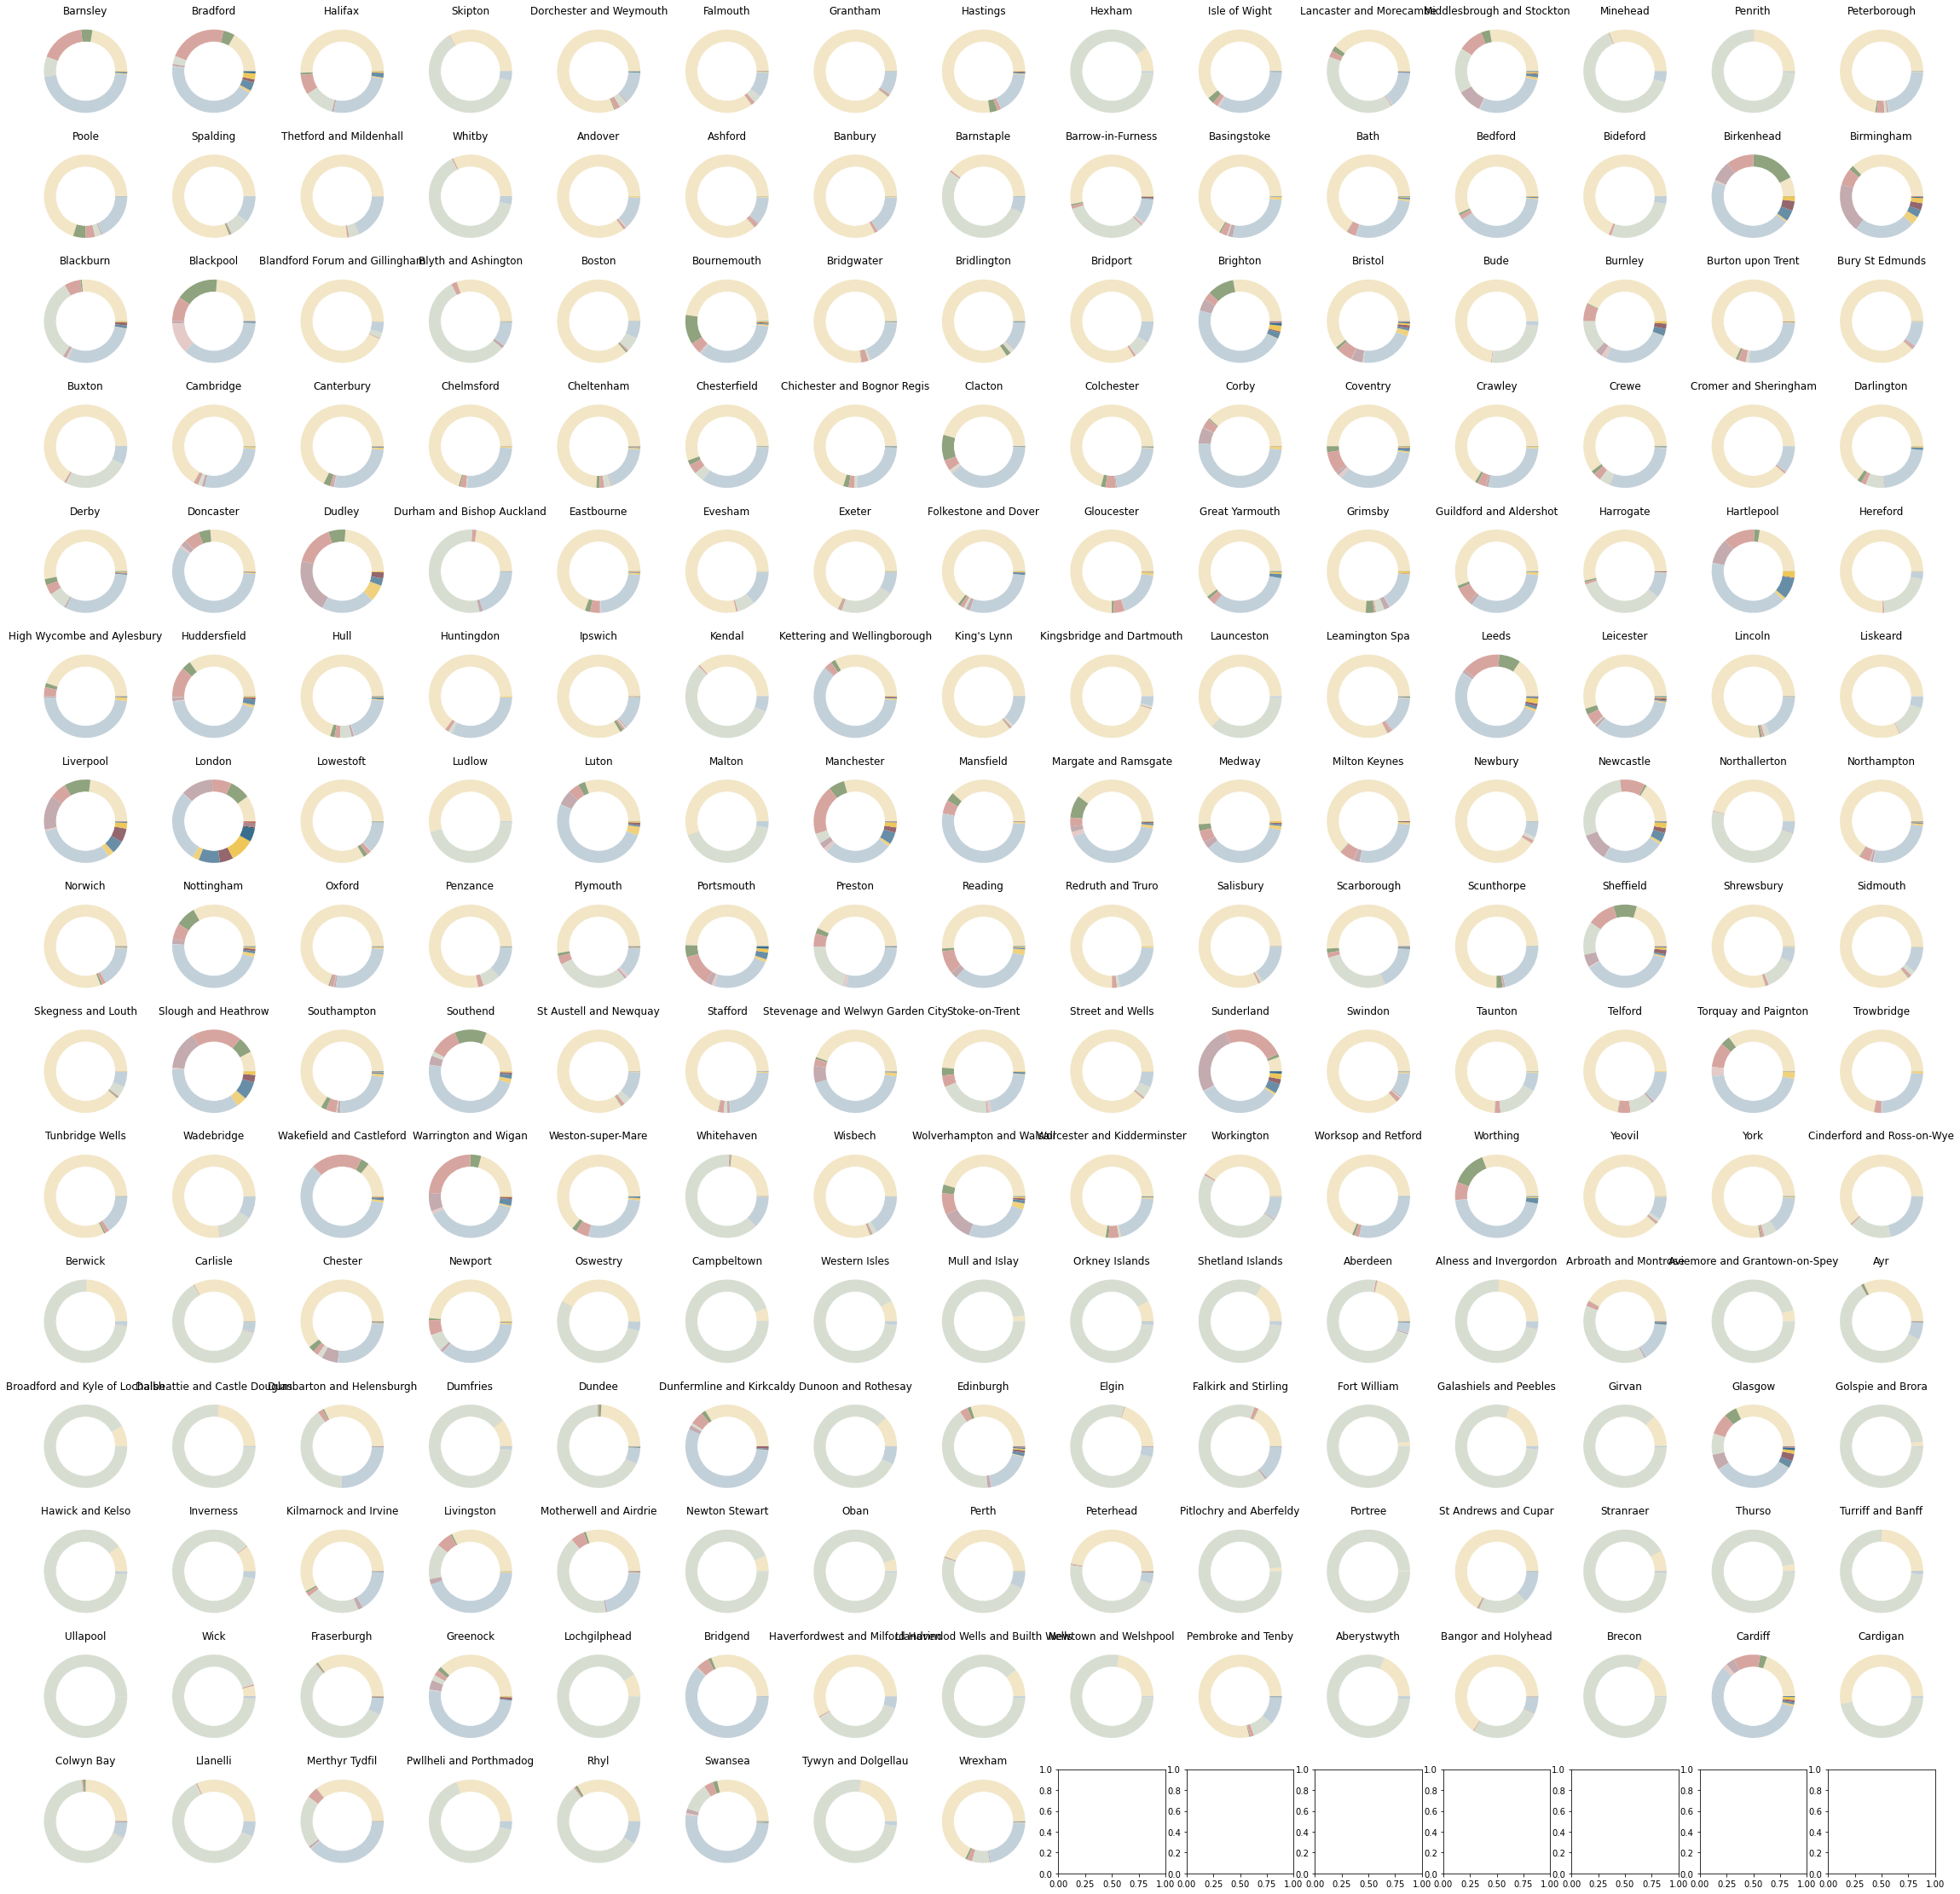

In [30]:
fig, axs = plt.subplots(15, 15, figsize=(40, 40))
axs = axs.flatten()
for i, place in enumerate(plot_data.columns):
    plot_data[place].plot.pie(colors=list(symbology.values()), labels=None, ax=axs[i], normalize=True)
    axs[i].axis("off")
    axs[i].add_artist(plt.Circle((0,0), .7, color="w"))
    axs[i].set_title(place)

In [31]:
interpolated = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

In [32]:
interpolated = interpolated.set_index("TTWA11NM")

In [33]:
plot_data = geopandas.GeoDataFrame(columns=["level", "order", "area", "urbanity", "geometry"], crs=interpolated.crs)

In [34]:
mapdata = interpolated.set_geometry(interpolated.centroid)

centres = ['Hyper concentrated urbanity', 'Concentrated urbanity', 'Metropolitan urbanity', 'Regional urbanity', 'Local urbanity', 'Dense urban neighbourhoods']
sizes = pandas.DataFrame()
for centre in centres:
    sizes[centre] = interpolated[centre] * interpolated.area

In [35]:
centroids = interpolated.centroid
for level, c in enumerate(centres):
    sub = interpolated[interpolated[c] > 0]
    area = sub.area
    sub["sorter"] = sub[c] * area
    sub = sub.sort_values("sorter", ascending=False)
    for i, ix in enumerate(sub.index):
        plot_data.loc[ix] = [level, i, sub["sorter"].loc[ix], c, centroids.loc[ix]]
    interpolated = interpolated.drop(sub.index)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [36]:
plot_data

,level,order,area,urbanity,geometry
London,0,0,1.306116e+06,Hyper concentrated urbanity,POINT (538745.517 181341.137)
Birmingham,2,0,1.075148e+06,Metropolitan urbanity,POINT (411388.314 285146.915)
Edinburgh,2,1,6.384964e+05,Metropolitan urbanity,POINT (336390.208 665534.358)
Glasgow,2,2,6.059172e+05,Metropolitan urbanity,POINT (254347.160 665607.051)
Manchester,2,3,5.153730e+05,Metropolitan urbanity,POINT (386789.011 394849.149)
...,...,...,...,...,...
Clacton,5,44,1.356900e+03,Dense urban neighbourhoods,POINT (616875.217 223103.518)
Yeovil,5,45,1.311523e+03,Dense urban neighbourhoods,POINT (353450.605 119753.694)
Kendal,5,46,8.299633e+02,Dense urban neighbourhoods,POINT (352724.630 492020.453)
Worksop and Retford,5,47,6.096959e+02,Dense urban neighbourhoods,POINT (468352.260 381552.153)


In [37]:
sizes = sizes.cumsum(axis=1)

In [38]:
sizes

,Hyper concentrated urbanity,Concentrated urbanity,Metropolitan urbanity,Regional urbanity,Local urbanity,Dense urban neighbourhoods
TTWA11NM,,,,,,
Barnsley,0.0,0.0,0.000000,0.000000,2.652940e+03,7.457278e+05
Bradford,0.0,0.0,0.000000,79723.179688,2.965356e+06,1.108895e+07
Halifax,0.0,0.0,0.000000,0.000000,2.213591e+05,2.167267e+06
Skipton,0.0,0.0,0.000000,0.000000,0.000000e+00,2.157967e+05
Dorchester and Weymouth,0.0,0.0,15383.532227,68559.571289,2.408603e+05,7.469582e+05
...,...,...,...,...,...,...
Pwllheli and Porthmadog,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Rhyl,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00
Swansea,0.0,0.0,0.000000,86499.750000,1.083695e+06,2.358544e+06


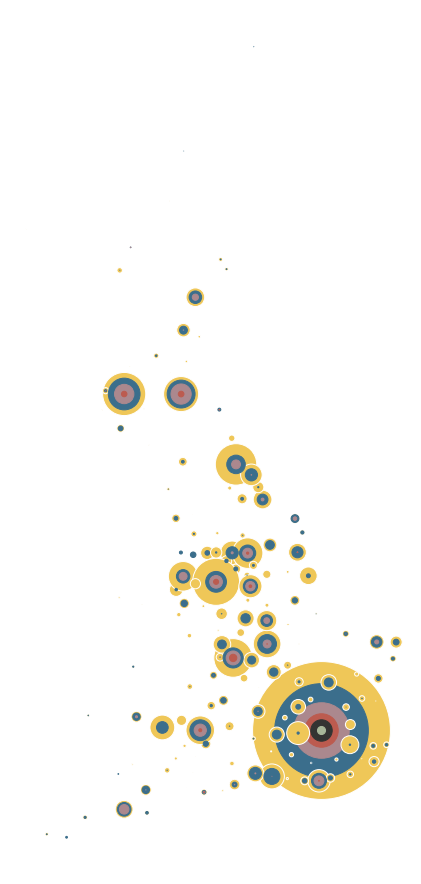

In [39]:
fig, ax = plt.subplots(figsize=(16, 16))
scaler = 20000

for i, centre in enumerate(centres[::-1]):
    if centre == 'Dense urban neighbourhoods':
        mapdata.drop("London").plot(markersize=sizes[centre].drop("London") / scaler, ax=ax, zorder=i+10, color=symbology[centre], edgecolor="w")
        mapdata.loc[["London"]].plot(markersize=sizes[centre].loc[["London"]] / scaler, ax=ax, zorder=i, color=symbology[centre], edgecolor="w")
    else:
        mapdata.drop("London").plot(markersize=sizes[centre].drop("London") / scaler, ax=ax, zorder=i+10, color=symbology[centre])
        mapdata.loc[["London"]].plot(markersize=sizes[centre].loc[["London"]] / scaler, ax=ax, zorder=i, color=symbology[centre])

ax.set_axis_off()
plt.savefig("figs/hierarchy_map.pdf")

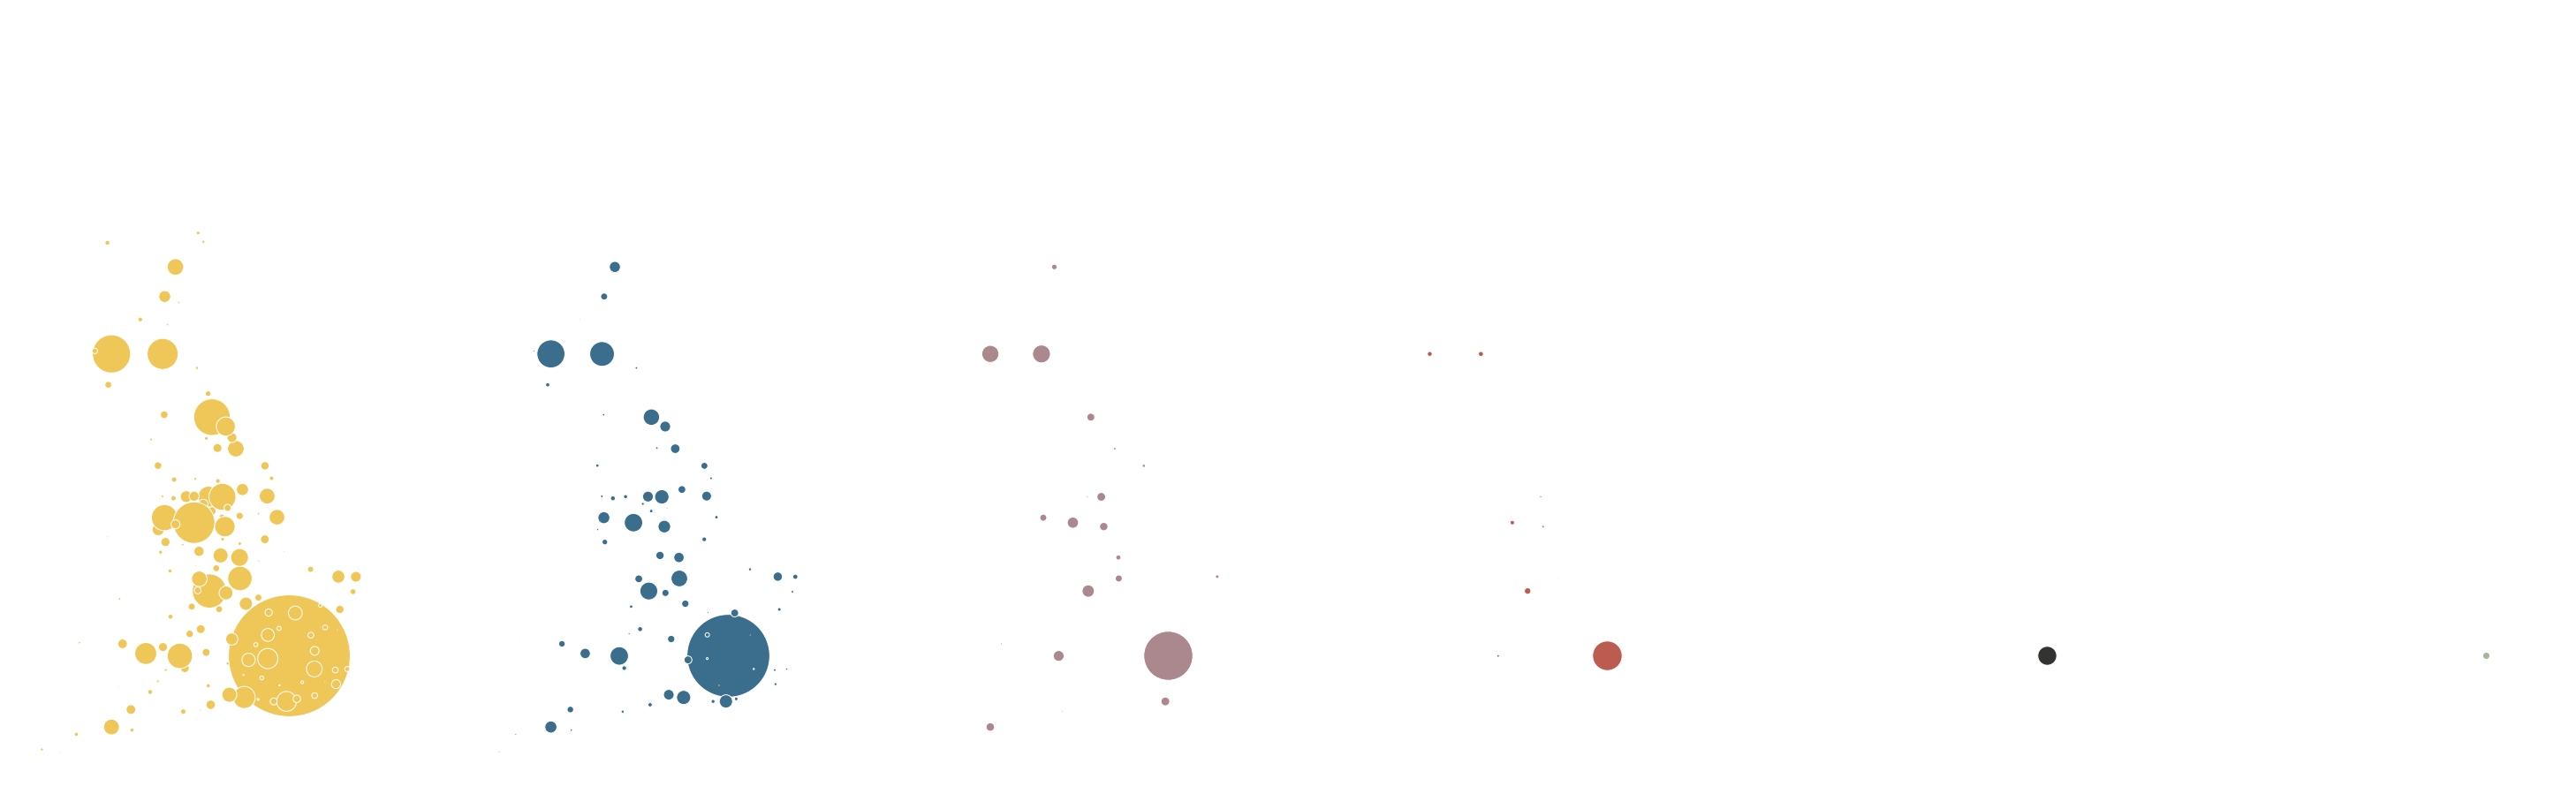

In [40]:
fig, axs = plt.subplots(1, 6, figsize=(52, 25))
scaler = 20000
axs = axs.flatten()

for i, centre in enumerate(centres[::-1]):
    mapdata.drop("London").plot(markersize=sizes[centre].drop("London") / scaler, ax=axs[i], zorder=i+10, color=symbology[centre], edgecolor="w")
    mapdata.loc[["London"]].plot(markersize=sizes[centre].loc[["London"]] / scaler, ax=axs[i], zorder=i, color=symbology[centre], edgecolor="w")

    axs[i].set_axis_off()
plt.savefig("figs/hierarchy_map_layers.pdf")

In [41]:
plot_data

,level,order,area,urbanity,geometry
London,0,0,1.306116e+06,Hyper concentrated urbanity,POINT (538745.517 181341.137)
Birmingham,2,0,1.075148e+06,Metropolitan urbanity,POINT (411388.314 285146.915)
Edinburgh,2,1,6.384964e+05,Metropolitan urbanity,POINT (336390.208 665534.358)
Glasgow,2,2,6.059172e+05,Metropolitan urbanity,POINT (254347.160 665607.051)
Manchester,2,3,5.153730e+05,Metropolitan urbanity,POINT (386789.011 394849.149)
...,...,...,...,...,...
Clacton,5,44,1.356900e+03,Dense urban neighbourhoods,POINT (616875.217 223103.518)
Yeovil,5,45,1.311523e+03,Dense urban neighbourhoods,POINT (353450.605 119753.694)
Kendal,5,46,8.299633e+02,Dense urban neighbourhoods,POINT (352724.630 492020.453)
Worksop and Retford,5,47,6.096959e+02,Dense urban neighbourhoods,POINT (468352.260 381552.153)


In [42]:
mapdata[["level", "order"]] = plot_data[["level", "order"]]

In [43]:
mapdata.order.max()

67

In [44]:
mapdata.loc[mapdata.level == 1, "order"] = mapdata.loc[mapdata.level == 1, "order"] * 5

In [45]:
mapdata.loc[mapdata.level == 2, "order"] = mapdata.loc[mapdata.level == 2, "order"] * 2.5
mapdata.loc[mapdata.level == 4, "order"] = mapdata.loc[mapdata.level == 4, "order"] * 1.5

In [46]:
for l in mapdata.level.dropna().unique():
    mapdata.loc[mapdata.level == l, "x"] = (mapdata.loc[mapdata.level == l, "order"] - mapdata.loc[mapdata.level == l, "order"].mean()) / mapdata.loc[mapdata.level == l, "order"].std()

In [47]:
mapdata.loc["London", 'x'] = 0 

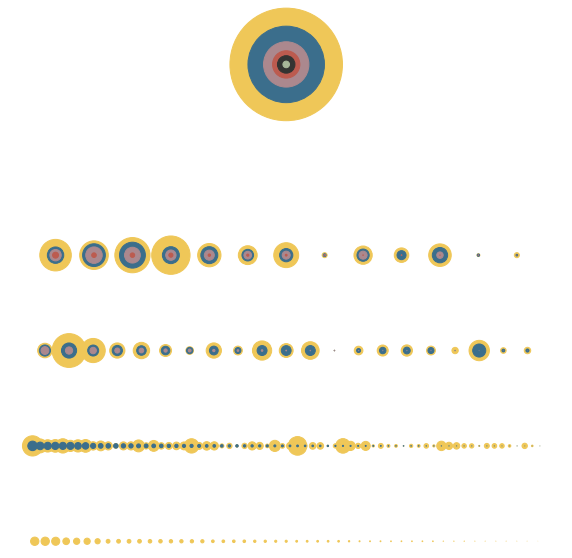

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
scaler = 30000

for i, centre in enumerate(centres[::-1]):
    ax.scatter(mapdata.x * 10, 1 - mapdata.level * 10, s=sizes[centre] / scaler, zorder=i+10, color=symbology[centre])

ax.set_axis_off()
# ax.axis('equal')
ax.set_ylim(-50, 7)
plt.savefig("figs/hierarchy_diagram.pdf")

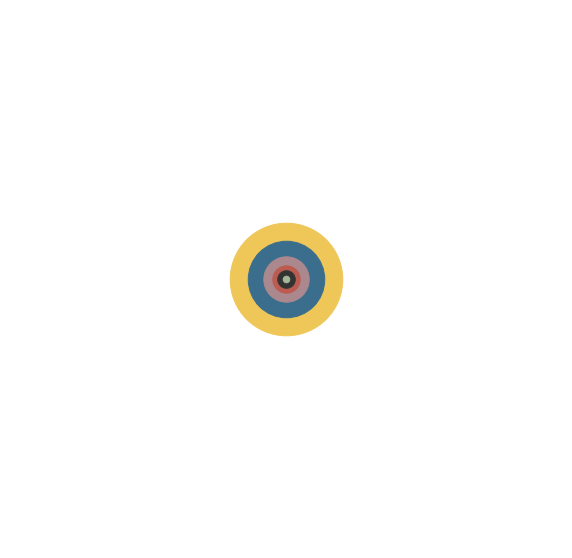

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
scaler = 30000

for i, centre in enumerate(centres[::-1]):
    ax.scatter(mapdata.loc[["London"]].x * 10, 1 - mapdata.loc[["London"]].level * 10, s=sizes.loc[["London"]][centre] / scaler, zorder=i+10, color=symbology[centre])

ax.set_axis_off()
# ax.axis('equal')
# ax.set_ylim(-42, 7)
plt.savefig("figs/hierarchy_london.pdf")

In [50]:
interpolated = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/esda/ttwa_interpolated.pq")

In [51]:
interpolated = interpolated.set_index("TTWA11NM")

In [52]:
interpolated

,Countryside agriculture,Accessible suburbia,Open sprawl,Wild countryside,Warehouse/Park land,Gridded residential quarters,Urban buffer,Disconnected suburbia,Dense residential neighbourhoods,Connected residential neighbourhoods,Dense urban neighbourhoods,Local urbanity,Concentrated urbanity,Regional urbanity,Metropolitan urbanity,Hyper concentrated urbanity,geometry,TTWA11CD
TTWA11NM,,,,,,,,,,,,,,,,,,
Barnsley,0.223470,0.043759,0.176207,0.078137,1.209109e-03,0.000215,0.464410,0.003625,0.006018,7.622296e-04,0.002179,0.000008,0.0,0.000000,0.000000,0.0,"POLYGON ((443116.607 409861.824, 444593.769 40...",E30000004
Bradford,0.167767,0.044535,0.228543,0.031195,8.260556e-03,0.002243,0.431150,0.008945,0.032706,1.263258e-02,0.023457,0.008332,0.0,0.000230,0.000000,0.0,"POLYGON ((404536.924 450487.224, 406675.831 44...",E30000018
Halifax,0.506016,0.008178,0.078606,0.116988,7.743638e-03,0.000413,0.252566,0.004335,0.018123,1.105669e-03,0.005320,0.000605,0.0,0.000000,0.000000,0.0,"POLYGON ((417371.807 423577.976, 417747.206 42...",E30000029
Skipton,0.333247,0.000010,0.002516,0.626520,6.712196e-04,0.000000,0.036192,0.000069,0.000568,4.415132e-07,0.000182,0.000000,0.0,0.000000,0.000000,0.0,"POLYGON ((399705.754 475251.492, 400486.847 47...",E30000039
Dorchester and Weymouth,0.803093,0.003389,0.021314,0.029620,4.454053e-03,0.000505,0.121557,0.000286,0.004360,4.049208e-04,0.000706,0.000240,0.0,0.000074,0.000021,0.0,"POLYGON ((381318.618 95599.564, 382904.110 952...",E30000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pwllheli and Porthmadog,0.294169,0.000185,0.000677,0.637449,1.737449e-05,0.000003,0.031029,0.000000,0.000199,1.370748e-05,0.000000,0.000000,0.0,0.000000,0.000000,0.0,"MULTIPOLYGON (((212467.543 322328.962, 210862....",W22000030
Rhyl,0.335685,0.009770,0.006090,0.555019,3.346282e-04,0.001034,0.089543,0.000154,0.000000,2.896387e-04,0.000000,0.000000,0.0,0.000000,0.000000,0.0,"POLYGON ((323624.950 374399.714, 321442.625 37...",W22000031
Swansea,0.285298,0.017182,0.035248,0.108456,1.686457e-02,0.007052,0.510910,0.001141,0.002975,1.466345e-03,0.001266,0.000990,0.0,0.000086,0.000000,0.0,"POLYGON ((298705.805 215503.170, 298231.853 21...",W22000032


In [53]:
for_heatmap = interpolated.drop(columns=["geometry", "TTWA11CD"])

In [54]:
for_heatmap.T

TTWA11NM,Barnsley,Bradford,Halifax,Skipton,Dorchester and Weymouth,Falmouth,Grantham,Hastings,Hexham,Isle of Wight,...,Cardiff,Cardigan,Colwyn Bay,Llanelli,Merthyr Tydfil,Pwllheli and Porthmadog,Rhyl,Swansea,Tywyn and Dolgellau,Wrexham
Countryside agriculture,0.223470,0.167767,0.506016,3.332466e-01,0.803093,0.818335,0.895052,0.767591,0.094503,0.599603,...,0.195818,0.523145,0.248822,0.314656,0.355109,0.294169,0.335685,0.285298,2.267002e-01,0.677904
Accessible suburbia,0.043759,0.044535,0.008178,9.679447e-06,0.003389,0.001462,0.003266,0.029322,0.000000,0.025276,...,0.026761,0.000000,0.008323,0.000882,0.001534,0.000185,0.009770,0.017182,7.951733e-05,0.008354
Open sprawl,0.176207,0.228543,0.078606,2.516165e-03,0.021314,0.014444,0.008395,0.015181,0.000812,0.019297,...,0.104238,0.000554,0.006357,0.004573,0.043850,0.000677,0.006090,0.035248,7.362045e-04,0.019103
Wild countryside,0.078137,0.031195,0.116988,6.265198e-01,0.029620,0.025869,0.000050,0.000017,0.897572,0.000087,...,0.000000,0.457116,0.666861,0.614383,0.203098,0.637449,0.555019,0.108456,7.490144e-01,0.068111
Warehouse/Park land,0.001209,0.008261,0.007744,6.712196e-04,0.004454,0.000537,0.000426,0.000163,0.000008,0.000908,...,0.033123,0.000037,0.002164,0.000003,0.009065,0.000017,0.000335,0.016865,8.903418e-07,0.003938
Gridded residential quarters,0.000215,0.002243,0.000413,0.000000e+00,0.000505,0.003124,0.000075,0.000000,0.000000,0.006657,...,0.018411,0.000000,0.000800,0.001571,0.002301,0.000003,0.001034,0.007052,0.000000e+00,0.000004
Urban buffer,0.464410,0.431150,0.252566,3.619192e-02,0.121557,0.094407,0.090790,0.165562,0.007011,0.324110,...,0.579492,0.007042,0.059214,0.059388,0.382751,0.031029,0.089543,0.510910,1.669930e-02,0.216287
Disconnected suburbia,0.003625,0.008945,0.004335,6.877031e-05,0.000286,0.002359,0.000676,0.003296,0.000010,0.000196,...,0.007812,0.000003,0.000006,0.000143,0.000539,0.000000,0.000154,0.001141,9.760898e-05,0.002296
Dense residential neighbourhoods,0.006018,0.032706,0.018123,5.675908e-04,0.004360,0.000202,0.001139,0.004595,0.000085,0.003108,...,0.008038,0.000000,0.000323,0.000008,0.000775,0.000199,0.000000,0.002975,0.000000e+00,0.002831
Connected residential neighbourhoods,0.000762,0.012633,0.001106,4.415132e-07,0.000405,0.001662,0.000002,0.003681,0.000000,0.000155,...,0.008753,0.000000,0.002737,0.000003,0.000977,0.000014,0.000290,0.001466,0.000000e+00,0.000426


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

In [56]:
order = ['Wild countryside', 'Countryside agriculture', 'Urban buffer',
       'Warehouse/Park land', 'Open sprawl', 'Disconnected suburbia',
       'Accessible suburbia', 'Connected residential neighbourhoods',
       'Dense residential neighbourhoods', 'Gridded residential quarters',
       'Dense urban neighbourhoods', 'Local urbanity', 'Regional urbanity',
       'Metropolitan urbanity', 'Concentrated urbanity',
       'Hyper concentrated urbanity'
    ]
order.reverse()
for_heatmap = for_heatmap[
    order
]

In [57]:
plot_data2 = geopandas.GeoDataFrame(columns=["level", "order", "area", "urbanity", "geometry"], crs=interpolated.crs)

In [58]:
sizes = pandas.DataFrame()
for centre in order:
    sizes[centre] = interpolated[centre] * interpolated.area

In [59]:
centroids = interpolated.centroid
for level, c in enumerate(order):
    sub = interpolated[interpolated[c] > 0]
    area = sub.area
    sub["sorter"] = sub[c] * area
    sub = sub.sort_values("sorter", ascending=False)
    for i, ix in enumerate(sub.index):
        plot_data2.loc[ix] = [level, i, sub["sorter"].loc[ix], c, centroids.loc[ix]]
    interpolated = interpolated.drop(sub.index)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [60]:
plot_data2

,level,order,area,urbanity,geometry
London,0,0,1.306116e+06,Hyper concentrated urbanity,POINT (538745.517 181341.137)
Birmingham,2,0,1.075148e+06,Metropolitan urbanity,POINT (411388.314 285146.915)
Edinburgh,2,1,6.384964e+05,Metropolitan urbanity,POINT (336390.208 665534.358)
Glasgow,2,2,6.059172e+05,Metropolitan urbanity,POINT (254347.160 665607.051)
Manchester,2,3,5.153730e+05,Metropolitan urbanity,POINT (386789.011 394849.149)
...,...,...,...,...,...
Portree,11,1,4.187323e+05,Open sprawl,POINT (139392.915 845200.808)
Newton Stewart,11,2,3.890446e+05,Open sprawl,POINT (243111.771 562519.436)
Mull and Islay,13,0,3.332326e+06,Urban buffer,POINT (143779.227 704221.821)
Lochgilphead,13,1,6.808734e+05,Urban buffer,POINT (188024.719 687097.024)


Per proportion within TTWA

<AxesSubplot:>

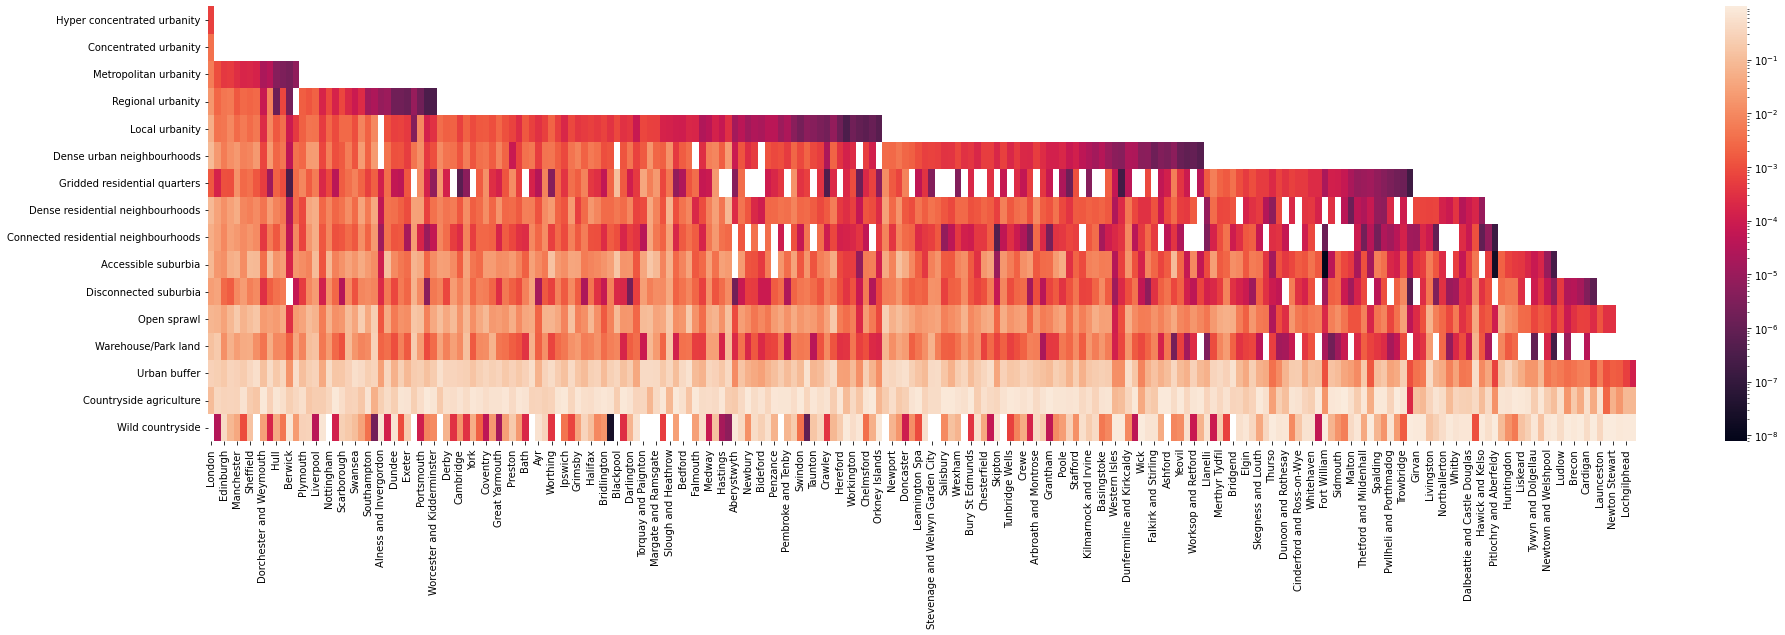

In [61]:
plt.subplots(figsize=(32, 8))
sns.heatmap(data=for_heatmap.loc[plot_data2.index].T, norm=LogNorm())

Per proportion of type within ttwa

<AxesSubplot:>

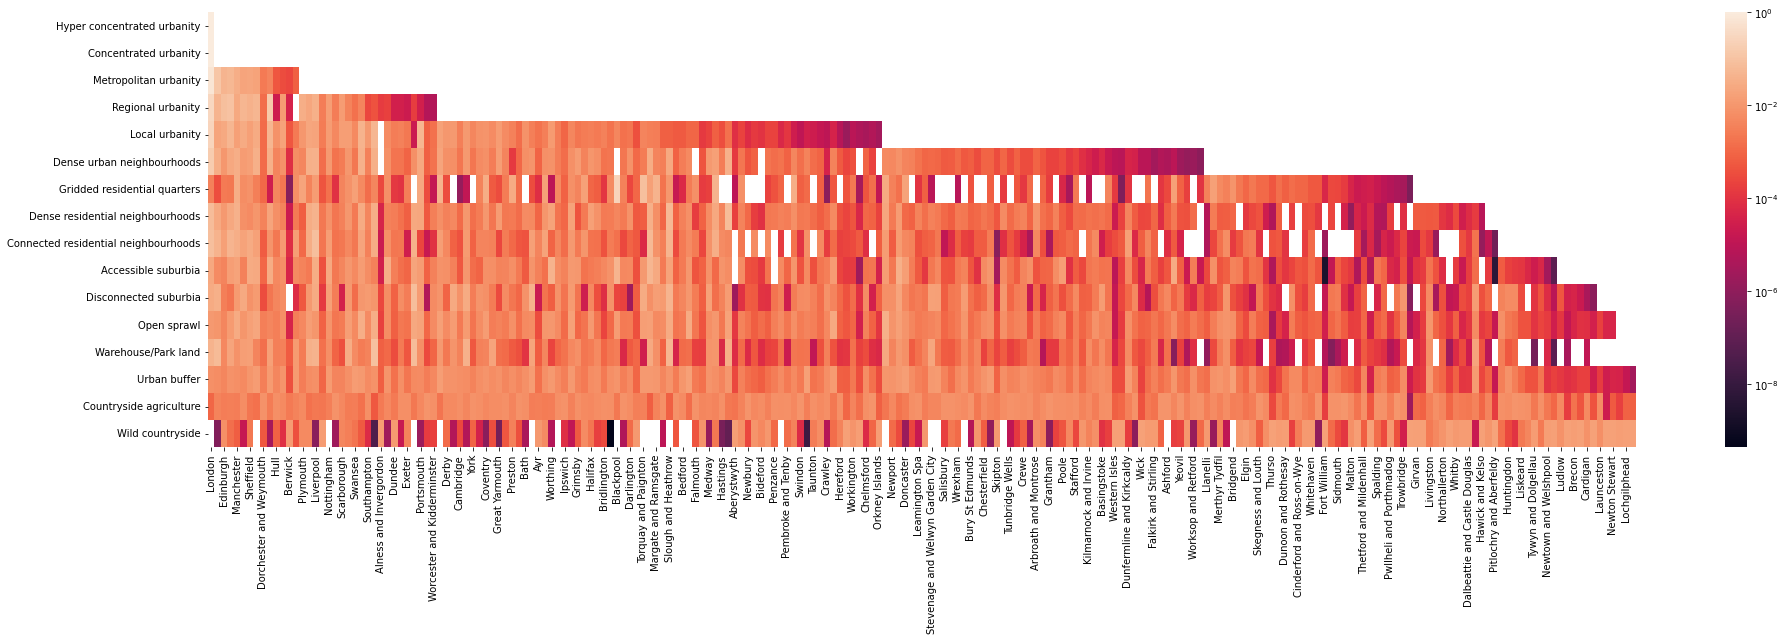

In [62]:
plt.subplots(figsize=(32, 8))
sns.heatmap(data=(for_heatmap / for_heatmap.sum(axis=0)).loc[plot_data2.index].T, norm=LogNorm())

<AxesSubplot:>

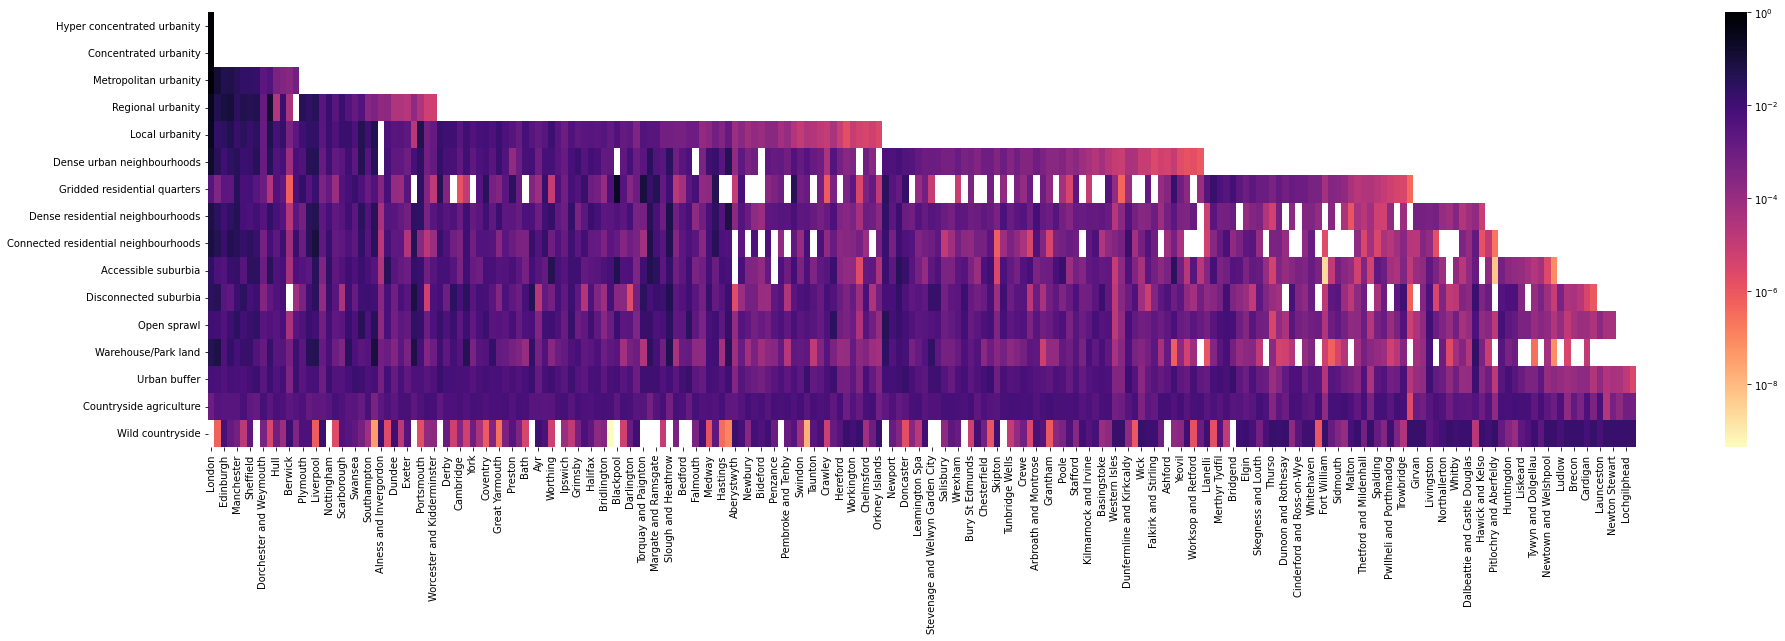

In [63]:
plt.subplots(figsize=(32, 8))
sns.heatmap(data=(for_heatmap / for_heatmap.sum(axis=0)).loc[plot_data2.index].T, norm=LogNorm(), cmap="magma_r")